In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# Load a csv
df=pd.read_csv('analysis_rfm_1010nooutlier.csv')

###### Encoding  Categorical Variable

In [2]:
from sklearn import preprocessing
le = preprocessing.LabelEncoder()
df['platform'] = le.fit_transform(df['platform'])
df['win_loss_quit'] = le.fit_transform(df['win_loss_quit'])
df['difficulty'] = le.fit_transform(df['difficulty'])
df['map_name'] = le.fit_transform(df['map_name'])
df['active_status'] = le.fit_transform(df['active_status'])

###### Balancing the imbalanced classes

In [ ]:
from imblearn.over_sampling import SMOTE
feature_cols = ['current_gold','current_gems','current_shards','frequency_in_total','app_opened_perday_median','map_name','easy_count','initial_ngames','avg_duration_mins','difficulty_skull','medium_count','hard_count','impoppable_count','active_weeks','initial_2_weeks','initial_nappopen','n_games','wlqgtr_cnt','lives_left' ]
X = df[feature_cols]# Features
y = df.active_status
X_resampled, y_resampled = SMOTE().fit_resample(X, y)
from collections import Counter
print(sorted(Counter(y_resampled).items()))

###### StandardScaler

In [3]:
from sklearn.preprocessing import StandardScaler
scaler = preprocessing.StandardScaler().fit(X_resampled)
scaled_X_resampled=scaler.transform(X_resampled)   
from sklearn.model_selection import train_test_split # Import train_test_split function
X_train, X_test, y_train, y_test = train_test_split(scaled_X_resampled, y_resampled, test_size=0.3, random_state=0)

Using TensorFlow backend.


[(0, 4284976), (1, 4284976), (2, 4284976)]


In [6]:
import numpy as np
idx=np.random.choice(y_train[y_train==0].shape[0],int(np.round(y_train.shape[0]*0.000002)))

In [12]:
idx

array([ 413739, 2812075, 2783045, 1006753, 2818682, 2994394, 2051289,
        354087, 2183515,  230971,  131921, 1869158, 1800691, 1511773,
       1027426, 1766905, 1148791, 2862034])

In [24]:
X_test[1766905]

array([-0.40611001, -0.26685048,  0.0949742 , -0.19501324, -0.09861129,
        0.69337818, -0.14948481, -0.15379819, -0.0306094 , -0.53210667,
       -0.3252009 , -0.12015568, -0.16694481, -0.21043177, -0.31432076,
       -0.14786971, -0.18561227,  0.48304599, -0.7440194 ])

In [4]:
import numpy as np
idx=np.random.choice(y_train[y_train==0].shape[0],int(np.round(y_train.shape[0]*0.2)))
print(sorted(Counter(y_train[idx]).items()))
idx2=np.random.choice(y_test.shape[0],int(np.round(y_test.shape[0]*0.2)))
print(sorted(Counter(y_test[idx2]).items()))

[(0, 600759), (1, 599078), (2, 599853)]
[(0, 258184), (1, 256410), (2, 256702)]


## DecisionTreeClassifier

In [5]:
from sklearn.tree import DecisionTreeClassifier
DecisionTree=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=20,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=10,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=None, splitter='best')

In [6]:
%timeit DecisionTree.fit(X_train[idx], y_train[idx])

1min 5s ± 1.67 s per loop (mean ± std. dev. of 7 runs, 1 loop each)


### DecisionTreeClassifier classification_report

In [10]:
y_pred=DecisionTree.predict(X_test[idx2])
from sklearn.metrics import classification_report
print(classification_report(y_test[idx2], y_pred))

              precision    recall  f1-score   support

           0       0.58      0.47      0.52    258184
           1       0.54      0.58      0.56    256410
           2       0.75      0.84      0.79    256702

    accuracy                           0.63    771296
   macro avg       0.62      0.63      0.62    771296
weighted avg       0.62      0.63      0.62    771296



#### Save Model

In [11]:
from sklearn.externals import joblib
# save the model to disk
filename = 'finalized_model_DecisionTree.hdf5'
joblib.dump(DecisionTree, filename)

['finalized_model_DecisionTree.hdf5']

### Feature importance

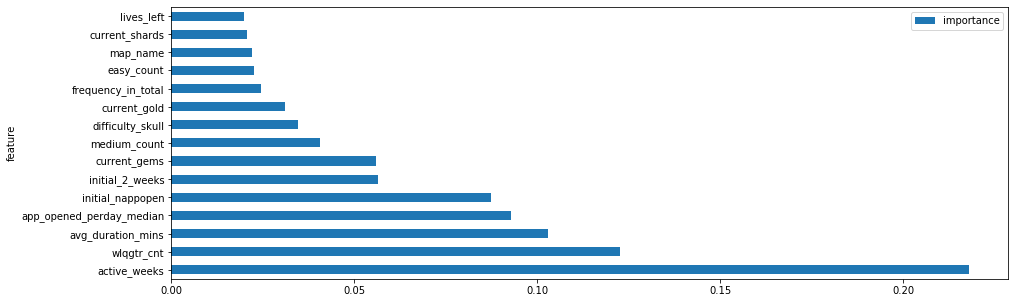

In [12]:
fi_model = pd.DataFrame({'feature': feature_cols,
                   'importance': DecisionTree.feature_importances_}).\
                    sort_values('importance', ascending = False)
fi_model.set_index('feature',inplace=True)

fi_model.head(15).sort_values('importance',ascending=False).plot.barh(figsize=(15, 5))

## Decision Tree Evaluation

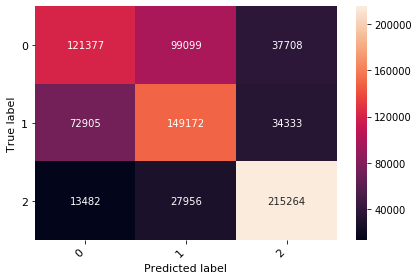

In [13]:
from sklearn.metrics import confusion_matrix
confusion_matrix= confusion_matrix(y_test[idx2], y_pred)#.argmax(axis=1))
confusion_matrix_df = pd.DataFrame(confusion_matrix)
heatmap = sns.heatmap(confusion_matrix_df, annot=True, annot_kws={"size": 10}, fmt="d")
heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize = 11)
heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha='right', fontsize = 11)
plt.ylabel('True label', fontsize = 11)
plt.xlabel('Predicted label', fontsize = 11)
plt.savefig('confusion_matrix_RandomForest.png')
plt.tight_layout()

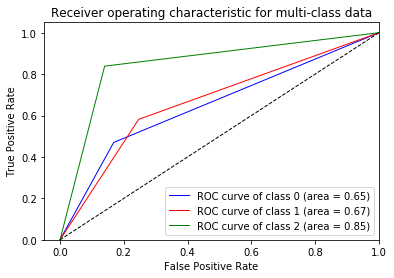

In [14]:
from sklearn.metrics import roc_curve, auc
from itertools import cycle
from sklearn.preprocessing import label_binarize
y = label_binarize(y, classes=[0, 1, 2])
n_classes = y.shape[1]
fpr = dict()
tpr = dict()
roc_auc = dict()
lb = preprocessing.LabelBinarizer()
lb.fit(y_test)
y_test_R = lb.transform(y_test[idx2])
y_pred_R = lb.transform(y_pred)
lw = 1
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_R[:,i], y_pred_R[:,i])
    roc_auc[i] = auc(fpr[i], tpr[i])
colors = cycle(['blue', 'red', 'green'])
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=lw,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(i, roc_auc[i]))
plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.xlim([-0.05, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic for multi-class data')
plt.legend(loc="lower right")
plt.show()


# LogisticRegression

In [40]:
from sklearn.linear_model import LogisticRegression
LogisticRegression=LogisticRegression(C=0.0001, class_weight={0: 0.6, 1: 0.4}, dual=False,
                   fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                   max_iter=100, multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='liblinear', tol=0.0001, verbose=0,
                   warm_start=False)
%timeit LogisticRegression.fit(X_train[idx], y_train[idx])
y_pred=LogisticRegression.predict(X_test[idx2])
from sklearn.metrics import classification_report
print(classification_report(y_test[idx2], y_pred))

/home/nkadmin/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
/home/nkadmin/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
/home/nkadmin/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
/home/nkadmin/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


32.7 s ± 136 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
              precision    recall  f1-score   support

           0       0.48      0.19      0.27    257930
           1       0.36      0.00      0.00    256502
           2       0.36      0.94      0.52    256864

    accuracy                           0.38    771296
   macro avg       0.40      0.38      0.26    771296
weighted avg       0.40      0.38      0.26    771296



In [41]:
print(classification_report(y_test[idx2], y_pred))

              precision    recall  f1-score   support

           0       0.48      0.19      0.27    257930
           1       0.36      0.00      0.00    256502
           2       0.36      0.94      0.52    256864

    accuracy                           0.38    771296
   macro avg       0.40      0.38      0.26    771296
weighted avg       0.40      0.38      0.26    771296



In [42]:
from sklearn.externals import joblib
# save the model to disk
filename = 'finalized_model_LogisticRegression.hdf5'
joblib.dump(LogisticRegression, filename)

['finalized_model_LogisticRegression.hdf5']

## LogisticRegression Evaluation

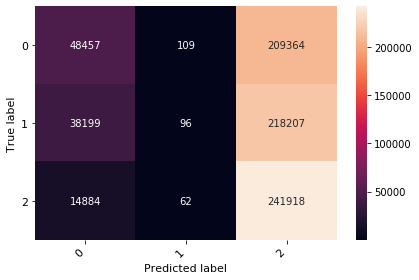

In [43]:
from sklearn.metrics import confusion_matrix
confusion_matrix= confusion_matrix(y_test[idx2], y_pred)#.argmax(axis=1))
confusion_matrix_df = pd.DataFrame(confusion_matrix)
heatmap = sns.heatmap(confusion_matrix_df, annot=True, annot_kws={"size": 10}, fmt="d")
heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize = 11)
heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha='right', fontsize = 11)
plt.ylabel('True label', fontsize = 11)
plt.xlabel('Predicted label', fontsize = 11)
plt.tight_layout()

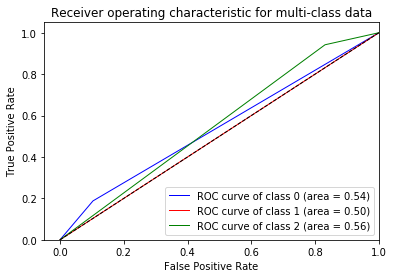

In [44]:
from sklearn.metrics import roc_curve, auc
from itertools import cycle
from sklearn.preprocessing import label_binarize
y = label_binarize(y, classes=[0, 1, 2])
n_classes = y.shape[1]
fpr = dict()
tpr = dict()
roc_auc = dict()
lb = preprocessing.LabelBinarizer()
lb.fit(y_test)
y_test_R = lb.transform(y_test[idx2])
y_pred = lb.transform(y_pred)
lw = 1
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_R[:,i], y_pred[:,i])
    roc_auc[i] = auc(fpr[i], tpr[i])
colors = cycle(['blue', 'red', 'green'])
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=lw,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(i, roc_auc[i]))
plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.xlim([-0.05, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic for multi-class data')
plt.legend(loc="lower right")
plt.show()


## AdaBoostClassifier 

In [45]:
#Executed
from sklearn.ensemble import AdaBoostClassifier
abc = AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None, learning_rate=1.0,
                   n_estimators=100, random_state=123)
model = abc.fit(X_train[idx], y_train[idx])
y_pred=model.predict(X_test[idx2])

## AdaBoostClassifier Evaluation

In [46]:
from sklearn.metrics import classification_report
print(classification_report(y_test[idx2], y_pred))

              precision    recall  f1-score   support

           0       0.51      0.35      0.41    257930
           1       0.50      0.40      0.45    256502
           2       0.59      0.90      0.71    256864

    accuracy                           0.55    771296
   macro avg       0.53      0.55      0.52    771296
weighted avg       0.53      0.55      0.52    771296



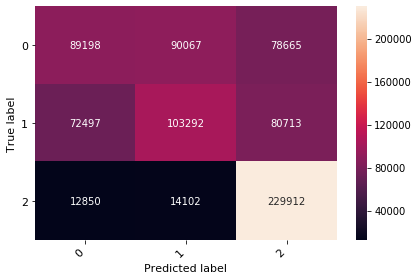

In [47]:
from sklearn.metrics import confusion_matrix
confusion_matrix= confusion_matrix(y_test[idx2], y_pred)#.argmax(axis=1))
confusion_matrix_df = pd.DataFrame(confusion_matrix)
heatmap = sns.heatmap(confusion_matrix_df, annot=True, annot_kws={"size": 10}, fmt="d")
heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize = 11)
heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha='right', fontsize = 11)
plt.ylabel('True label', fontsize = 11)
plt.xlabel('Predicted label', fontsize = 11)
plt.tight_layout()

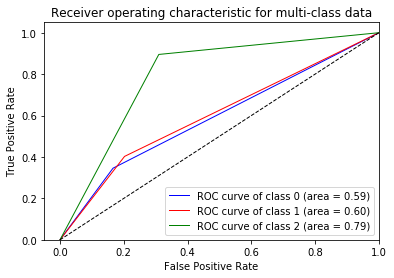

In [48]:
from sklearn.metrics import roc_curve, auc
from itertools import cycle
from sklearn.preprocessing import label_binarize
y = label_binarize(y, classes=[0, 1, 2])
n_classes = y.shape[1]
fpr = dict()
tpr = dict()
roc_auc = dict()
lb = preprocessing.LabelBinarizer()
lb.fit(y_test)
y_test_R = lb.transform(y_test[idx2])
y_pred = lb.transform(y_pred)
lw = 1
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_R[:,i], y_pred[:,i])
    roc_auc[i] = auc(fpr[i], tpr[i])
colors = cycle(['blue', 'red', 'green'])
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=lw,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(i, roc_auc[i]))
plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.xlim([-0.05, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic for multi-class data')
plt.legend(loc="lower right")
plt.show()

    ## SGDClassifier 

In [49]:
from sklearn.linear_model import SGDClassifier
SGD = SGDClassifier(alpha=0.001, average=False, class_weight=None,
              early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
              l1_ratio=0.15, learning_rate='optimal', loss='log', max_iter=1000,
              n_iter_no_change=5, n_jobs=None, penalty='none', power_t=0.5,
              random_state=None, shuffle=True, tol=0.001,
              validation_fraction=0.1, verbose=0, warm_start=False)
SGD = SGD.fit(X_train[idx], y_train[idx])
y_pred=SGD.predict(X_test[idx2])

In [54]:
y_pred=SGD.predict(X_test[idx2])

## SGDClassifier Evaluation

In [50]:
from sklearn.metrics import classification_report
print(classification_report(y_test[idx2], y_pred))

              precision    recall  f1-score   support

           0       0.45      0.28      0.34    257930
           1       0.37      0.18      0.24    256502
           2       0.39      0.74      0.51    256864

    accuracy                           0.40    771296
   macro avg       0.40      0.40      0.36    771296
weighted avg       0.40      0.40      0.36    771296



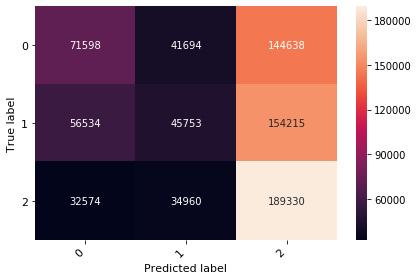

In [51]:
from sklearn.metrics import confusion_matrix
confusion_matrix= confusion_matrix(y_test[idx2], y_pred)#.argmax(axis=1))
confusion_matrix_df = pd.DataFrame(confusion_matrix)
heatmap = sns.heatmap(confusion_matrix_df, annot=True, annot_kws={"size": 10}, fmt="d")
heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize = 11)
heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha='right', fontsize = 11)
plt.ylabel('True label', fontsize = 11)
plt.xlabel('Predicted label', fontsize = 11)
plt.tight_layout()

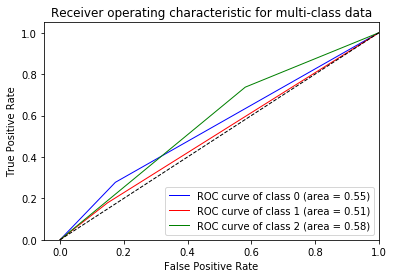

In [55]:
from sklearn.metrics import roc_curve, auc
from itertools import cycle
from sklearn.preprocessing import label_binarize
y = label_binarize(y, classes=[0, 1, 2])
n_classes = y.shape[1]
fpr = dict()
tpr = dict()
roc_auc = dict()
lb = preprocessing.LabelBinarizer()
lb.fit(y_test)
y_test_R = lb.transform(y_test[idx2])
y_pred_R = lb.transform(y_pred)
lw = 1
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_R[:,i], y_pred_R[:,i])
    roc_auc[i] = auc(fpr[i], tpr[i])
colors = cycle(['blue', 'red', 'green'])
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=lw,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(i, roc_auc[i]))
plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.xlim([-0.05, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic for multi-class data')
plt.legend(loc="lower right")
plt.show()

## KNeighborsClassifier

In [19]:
from sklearn.neighbors import KNeighborsClassifier
Knn_1=KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='manhattan',
                     metric_params=None, n_jobs=None, n_neighbors=3, p=2,
                     weights='distance')
Knn_1.fit(X_train[idx], y_train[idx])

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='manhattan',
                     metric_params=None, n_jobs=None, n_neighbors=3, p=2,
                     weights='distance')

In [20]:
y_pred=Knn_1.predict(X_test[idx2])
from sklearn.metrics import classification_report
print(classification_report(y_test[idx2], y_pred))

              precision    recall  f1-score   support

           0       0.71      0.73      0.72    258184
           1       0.75      0.78      0.76    256410
           2       0.77      0.71      0.73    256702

    accuracy                           0.74    771296
   macro avg       0.74      0.74      0.74    771296
weighted avg       0.74      0.74      0.74    771296



In [21]:
from sklearn.externals import joblib
# save the model to disk
filename = 'finalized_model_KNN.hdf5'
joblib.dump(Knn_1, filename)

['finalized_model_KNN.hdf5']

In [59]:
from sklearn.externals import joblib
# save the model to disk
filename = 'finalized_model_SGD.hdf5'
joblib.dump(SGD, filename)

['finalized_model_SGD.hdf5']

In [60]:
from sklearn.externals import joblib
# save the model to disk
filename = 'finalized_model_Adaboosting.hdf5'
joblib.dump(model, filename)

['finalized_model_Adaboosting.hdf5']

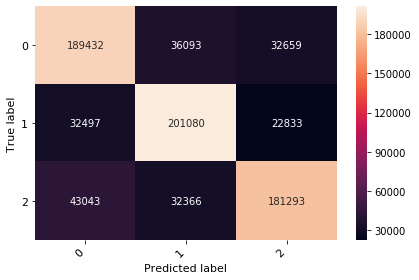

In [22]:
from sklearn.metrics import confusion_matrix
confusion_matrix= confusion_matrix(y_test[idx2], y_pred)
confusion_matrix_df = pd.DataFrame(confusion_matrix)
heatmap = sns.heatmap(confusion_matrix_df, annot=True, annot_kws={"size": 10}, fmt="d")
heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize = 11)
heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha='right', fontsize = 11)
plt.ylabel('True label', fontsize = 11)
plt.xlabel('Predicted label', fontsize = 11)
plt.tight_layout()

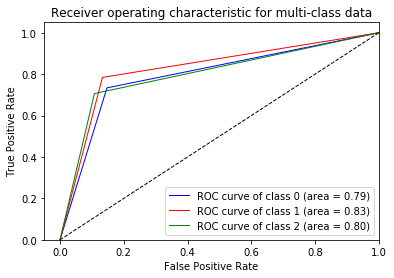

In [23]:
from sklearn.metrics import roc_curve, auc
from itertools import cycle
from sklearn.preprocessing import label_binarize
y = label_binarize(y, classes=[0, 1, 2])
n_classes = y.shape[1]
fpr = dict()
tpr = dict()
roc_auc = dict()
lb = preprocessing.LabelBinarizer()
lb.fit(y_test)
y_test_R = lb.transform(y_test[idx2])
y_pred_R = lb.transform(y_pred)
lw = 1
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_R[:,i], y_pred_R[:,i])
    roc_auc[i] = auc(fpr[i], tpr[i])
colors = cycle(['blue', 'red', 'green'])
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=lw,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(i, roc_auc[i]))
plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.xlim([-0.05, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic for multi-class data')
plt.legend(loc="lower right")
plt.show()

In [15]:
from sklearn.ensemble import RandomForestClassifier
RandomForest=RandomForestClassifier(bootstrap=False, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=300,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)
RandomForest= RandomForest.fit(X_train[idx], y_train[idx])
y_pred=RandomForest.predict(X_test[idx2])
from sklearn.metrics import classification_report
print(classification_report(y_test[idx2], y_pred))

              precision    recall  f1-score   support

           0       0.79      0.75      0.77    258184
           1       0.78      0.79      0.79    256410
           2       0.85      0.88      0.87    256702

    accuracy                           0.81    771296
   macro avg       0.81      0.81      0.81    771296
weighted avg       0.81      0.81      0.81    771296



In [16]:
from sklearn.externals import joblib
# save the model to disk
filename = 'finalized_model_RandomForest.hdf5'
joblib.dump(RandomForest, filename)

['finalized_model_RandomForest.hdf5']

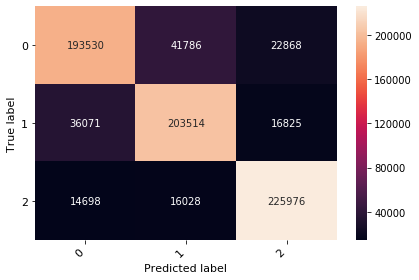

In [17]:
from sklearn.metrics import confusion_matrix
confusion_matrix= confusion_matrix(y_test[idx2], y_pred)#.argmax(axis=1))
confusion_matrix_df = pd.DataFrame(confusion_matrix)
heatmap = sns.heatmap(confusion_matrix_df, annot=True, annot_kws={"size": 10}, fmt="d")
heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize = 11)
heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha='right', fontsize = 11)
plt.ylabel('True label', fontsize = 11)
plt.xlabel('Predicted label', fontsize = 11)
plt.savefig('confusion_matrix_RandomForest.png')
plt.tight_layout()

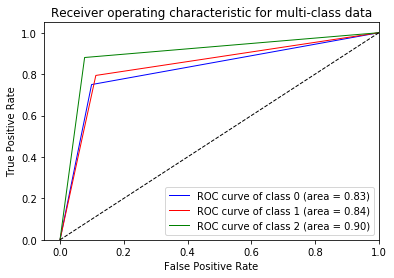

In [18]:
from sklearn.metrics import roc_curve, auc
from itertools import cycle
from sklearn.preprocessing import label_binarize
y = label_binarize(y, classes=[0, 1, 2])
n_classes = y.shape[1]
fpr = dict()
tpr = dict()
roc_auc = dict()
lb = preprocessing.LabelBinarizer()
lb.fit(y_test)
y_test_R = lb.transform(y_test[idx2])
y_pred_R = lb.transform(y_pred)
lw = 1
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_R[:,i], y_pred_R[:,i])
    roc_auc[i] = auc(fpr[i], tpr[i])
colors = cycle(['blue', 'red', 'green'])
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=lw,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(i, roc_auc[i]))
plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.xlim([-0.05, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic for multi-class data')
plt.legend(loc="lower right")
plt.show()

In [24]:
print('DecisionTree: {}'.format(DecisionTree.score(X_test[idx2], y_test[idx2])))
print('RandomForest: {}'.format(RandomForest.score(X_test[idx2], y_test[idx2])))
#print('LogisticRegression: {}'.format(LogisticRegression.score(X_test[idx2], y_test[idx2])))
#print('Adaboosting: {}'.format(model.score(X_test[idx2], y_test[idx2])))
#print('StochasticGradientDescent: {}'.format(SGD.score(X_test[idx2], y_test[idx2])))
print('KNearestNeighbors: {}'.format(Knn_1.score(X_test[idx2], y_test[idx2])))

DecisionTree: 0.6298658362029623
RandomForest: 0.8077573331120608
KNearestNeighbors: 0.7413561071235946


In [69]:
from sklearn.ensemble import VotingClassifier
#create a dictionary of our models
estimators=[('DecisionTree', DecisionTree), ('RandomForest', RandomForest),('KNearestNeighbors', Knn_1)]
#create our voting classifier, inputting our models
ensemble = VotingClassifier(estimators, voting='hard')

In [71]:
#fit model to training data
ensemble.fit(X_train[idx], y_train[idx])
#test our model on the test data
ensemble.score(X_test[idx2], y_test[idx2])

/home/nkadmin/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


0.6940111189478488

In [73]:
y_pred=ensemble.predict(X_test[idx2])

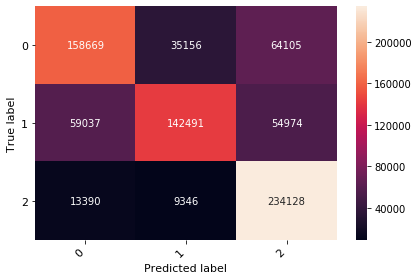

In [74]:
from sklearn.metrics import confusion_matrix
confusion_matrix= confusion_matrix(y_test[idx2], y_pred)
confusion_matrix_df = pd.DataFrame(confusion_matrix)
heatmap = sns.heatmap(confusion_matrix_df, annot=True, annot_kws={"size": 10}, fmt="d")
heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize = 11)
heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha='right', fontsize = 11)
plt.ylabel('True label', fontsize = 11)
plt.xlabel('Predicted label', fontsize = 11)
plt.tight_layout()

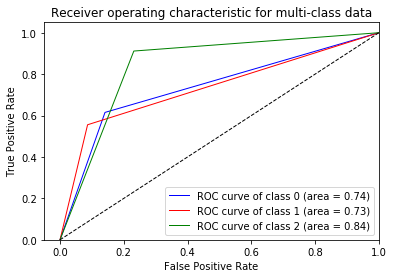

In [75]:
from sklearn.metrics import roc_curve, auc
from itertools import cycle
from sklearn.preprocessing import label_binarize
y = label_binarize(y, classes=[0, 1, 2])
n_classes = y.shape[1]
fpr = dict()
tpr = dict()
roc_auc = dict()
lb = preprocessing.LabelBinarizer()
lb.fit(y_test)
y_test_R = lb.transform(y_test[idx2])
y_pred_R = lb.transform(y_pred)
lw = 1
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_R[:,i], y_pred_R[:,i])
    roc_auc[i] = auc(fpr[i], tpr[i])
colors = cycle(['blue', 'red', 'green'])
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=lw,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(i, roc_auc[i]))
plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.xlim([-0.05, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic for multi-class data')
plt.legend(loc="lower right")
plt.show()

In [30]:
from sklearn.externals import joblib
# save the model to disk
filename = 'Ensemble1_Model.pkl'
joblib.dump(ensemble1, filename)

['Ensemble1_Model.pkl']

In [ ]:
#fit model to training data
ensemble1.fit(X_train[idx], y_train[idx])
#test our model on the test data
ensemble1.score(X_test[idx2], y_test[idx2])

In [26]:
from sklearn.ensemble import VotingClassifier
#create a dictionary of our models
estimators1=[('DecisionTree', DecisionTree), ('RandomForest', RandomForest), ('KNearestNeighbors', Knn_1)]
#create our voting classifier, inputting our models
ensemble1 = VotingClassifier(estimators1, voting='hard')
#fit model to training data
ensemble1.fit(X_train[idx], y_train[idx])
#test our model on the test data
ensemble1.score(X_test[idx2], y_test[idx2])
y_pred1=ensemble1.predict(X_test[idx2])

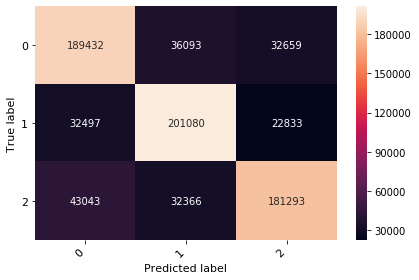

In [28]:
from sklearn.metrics import confusion_matrix
confusion_matrix= confusion_matrix(y_test[idx2], y_pred)
confusion_matrix_df = pd.DataFrame(confusion_matrix)
heatmap = sns.heatmap(confusion_matrix_df, annot=True, annot_kws={"size": 10}, fmt="d")
heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize = 11)
heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha='right', fontsize = 11)
plt.ylabel('True label', fontsize = 11)
plt.xlabel('Predicted label', fontsize = 11)
plt.tight_layout()

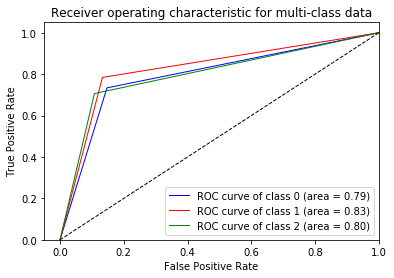

In [29]:
from sklearn.metrics import roc_curve, auc
from itertools import cycle
from sklearn.preprocessing import label_binarize
y = label_binarize(y, classes=[0, 1, 2])
n_classes = y.shape[1]
fpr = dict()
tpr = dict()
roc_auc = dict()
lb = preprocessing.LabelBinarizer()
lb.fit(y_test)
y_test_R = lb.transform(y_test[idx2])
y_pred_R = lb.transform(y_pred)
lw = 1
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_R[:,i], y_pred_R[:,i])
    roc_auc[i] = auc(fpr[i], tpr[i])
colors = cycle(['blue', 'red', 'green'])
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=lw,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(i, roc_auc[i]))
plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.xlim([-0.05, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic for multi-class data')
plt.legend(loc="lower right")
plt.show()

In [ ]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score


print(accuracy_score(y_test,y_pred ))
print(precision_score(y_test, y_pred,pos_label='positive',average='weighted'))
print(recall_score(y_test, y_pred,pos_label='positive',average='weighted'))
print(f1_score(y_test, y_pred,pos_label='positive',average='weighted'))


In [ ]:
from sklearn import svm
clf = svm.SVC(gamma='scale', decision_function_shape='ovo')

In [ ]:
clf.fit(x_train, y_train)